# DATA

In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.10.0


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100


**preproccessing**:

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/merged/dataset" ,
    validation_split=0.3,  # 30% validation
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/merged/dataset",
    validation_split=0.1,  # 10% validation
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/merged/dataset",
    validation_split=0.1,  # 10% testing
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)



Found 15888 files belonging to 4 classes.
Using 11122 files for training.
Found 15888 files belonging to 4 classes.
Using 1588 files for validation.
Found 15888 files belonging to 4 classes.
Using 1588 files for validation.


In [22]:
class_names = ['Mild_Dementia', 'Moderate_Dementia', 'Non_Dementia', 'Very_Mild_Dementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)


**one hot encoding**

In [23]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)



In [25]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



# **model building**

In [26]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [27]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [28]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model







In [29]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [30]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

**model fitting**

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
696/696 [==============================] - 459s 654ms/step - loss: 1.1696 - auc: 0.7438 - val_loss: 3.2822 - val_auc: 0.6687 - lr: 0.0100
Epoch 2/100
696/696 [==============================] - 440s 631ms/step - loss: 0.9957 - auc: 0.8190 - val_loss: 1.2272 - val_auc: 0.7964 - lr: 0.0089
Epoch 3/100
696/696 [==============================] - 408s 586ms/step - loss: 0.8992 - auc: 0.8556 - val_loss: 1.1662 - val_auc: 0.8137 - lr: 0.0079
Epoch 4/100
696/696 [==============================] - 415s 596ms/step - loss: 0.8325 - auc: 0.8775 - val_loss: 1.4203 - val_auc: 0.8145 - lr: 0.0071
Epoch 5/100
696/696 [==============================] - 406s 583ms/step - loss: 0.7089 - auc: 0.9114 - val_loss: 0.5290 - val_auc: 0.9497 - lr: 0.0063
Epoch 6/100
696/696 [==============================] - 408s 586ms/step - loss: 0.6302 - auc: 0.9293 - val_loss: 0.5886 - val_auc: 0.9391 - lr: 0.0056
Epoch 7/100
696/696 [==============================] - 398s 571ms/step - loss: 0.5657 - auc: 0.9429 

**testing with test data**

In [39]:

_ = model.evaluate(test_ds)


100/100 [==============================] - 3s 34ms/step - loss: 0.1715 - auc: 0.9944


In [41]:
from tensorflow.keras.models import load_model, save_model

# Assuming your model variable is named 'model'
model_path = "data/saved_models/alzheimer_model_merged_id1.h5"
save_model(model, model_path)

print("Model saved successfully at:", model_path)



Model saved successfully at: data/saved_models/alzheimer_model_merged_id1.h5


100/100 [==============================] - 4s 35ms/step


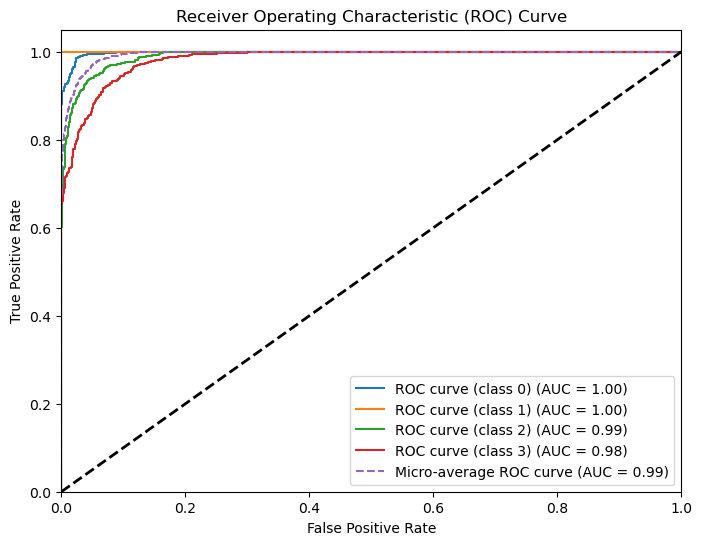

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test data
predictions = model.predict(test_ds)

# Extract true labels from test_ds
true_labels = []
for batch in test_ds:
    true_labels.extend(batch[1].numpy())  # Assuming labels are in the second position of each batch

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 4  # Assuming you have 4 classes
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels)[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(np.array(true_labels).ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



100/100 [==============================] - 3s 33ms/step


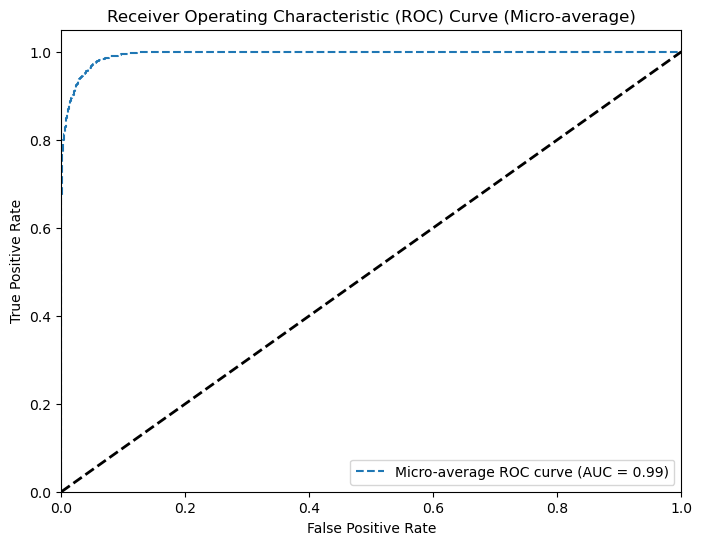

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test data
predictions = model.predict(test_ds)

# Extract true labels from test_ds
true_labels = []
for batch in test_ds:
    true_labels.extend(batch[1].numpy())  # Assuming labels are in the second position of each batch

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(np.array(true_labels).ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Micro-average)')
plt.legend(loc="lower right")
plt.show()



In [74]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
# Define the path to the image you want to classify
image_path = 'normal.jpg'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(176,208))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Perform inference
predictions = model.predict(img_array)

# Convert the predicted probabilities to class labels
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_names[predicted_class_index]

# Print the predicted class label and class name
print("Predicted class label:", predicted_class_label)
print("Predicted class name:", class_names[predicted_class_index])
# Print the predicted class label
print("Predicted class:", predicted_class_label)

1/1 [==============================] - 0s 453ms/step
Predicted class label: Non_Dementia
Predicted class name: Non_Dementia
Predicted class: Non_Dementia


In [62]:

# Create a dictionary to map class indices to class names
class_index_to_name = {index: name for index, name in enumerate(class_names)}

# Example usage: To find out the class name corresponding to class index 2 (Non_Dementia)
class_index = 3
class_name = class_index_to_name[class_index]
print(f"Class {class_index} is '{class_name}'")

Class 3 is 'Very_Mild_Dementia'


In [ ]:

# Define num_classes based on your problem

# MODEL LAYERS
model=Sequential()
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(176, 208, 1)))
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

# Compile the model
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 25)      250       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 75)      16950     
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 104, 75)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 686400)            0         
                                                                 
 dense (Dense)               (None, 500)               343200500 
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                      

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [49]:
# After training the model
model.save("/content/drive/MyDrive/saved_models/alzheimer_model2.h5")
from tensorflow.keras.models import load_model

# Load the saved model
saved_model = load_model("/content/drive/MyDrive/saved_models/alzheimer_model2.h5")

